In [18]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [19]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.16.1
TensorFlow Decision Forests v1.9.0


In [20]:
train_file_path = "data/train.csv"
dataset_df = pd.read_csv(train_file_path)
dataset_df = dataset_df.drop('Id', axis=1)

/var/folders/_8/s86gthys1d7dsy7_0r3l3f_m0000gn/T/ipykernel_9558/4247080571.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


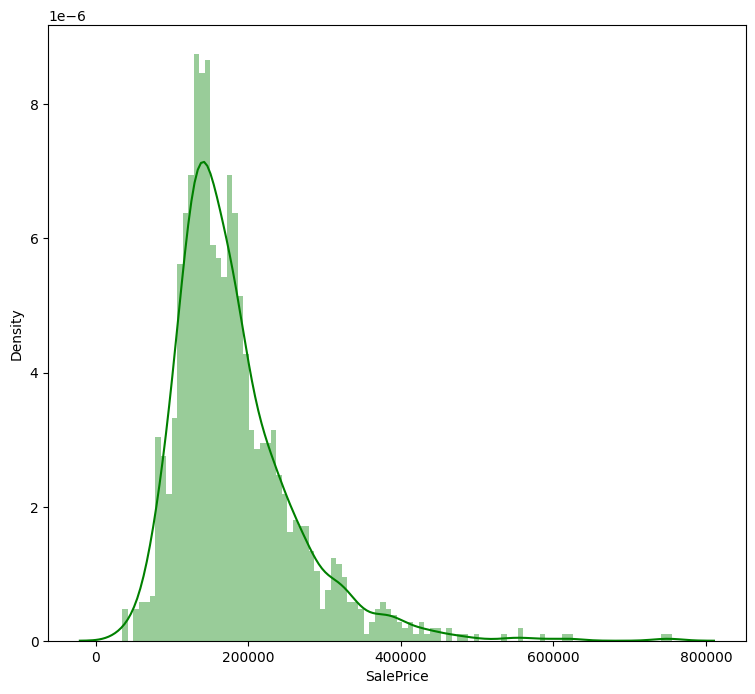

In [21]:
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [22]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


The Dataset Preparation

In [23]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1028 examples in training, 432 examples in testing.


In [24]:
label = 'SalePrice'

In [25]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

In [26]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /var/folders/_8/s86gthys1d7dsy7_0r3l3f_m0000gn/T/tmp2jvobdty as temporary training directory


In [27]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:06.621468. Found 1028 examples.
Training model...
Model trained in 0:00:00.847358
Compiling model...


[INFO 24-06-26 21:23:58.6045 +0545 kernel.cc:1233] Loading model from path /var/folders/_8/s86gthys1d7dsy7_0r3l3f_m0000gn/T/tmp2jvobdty/model/ with prefix 06bf381aafc9421c
[INFO 24-06-26 21:23:58.7907 +0545 decision_forest.cc:734] Model loaded with 300 root(s), 97880 node(s), and 74 input feature(s).
[INFO 24-06-26 21:23:58.7907 +0545 abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-06-26 21:23:58.7908 +0545 kernel.cc:1061] Use fast generic engine


Model compiled.


In [28]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

In [29]:
test_file_path = "data/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 31ms/step


,Id,SalePrice
0,1461,125910.070312
1,1462,156739.921875
2,1463,176866.109375
3,1464,182430.046875
4,1465,202064.015625


In [33]:
sample_submission_df = pd.read_csv('data/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
# sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.to_csv('submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 1s 90ms/step


,Id,SalePrice
0,1461,125910.070312
1,1462,156739.921875
2,1463,176866.109375
3,1464,182430.046875
4,1465,202064.015625
